# Money in the NFL: An Analysis of Spending and Its Effects on Performance

## Brandon Gormley

The National Football League (NFL) today draws more attention - and money - than ever in its history. Last year, despite the pandemic, the NFL generated almost [$10 billion in revenue.](https://www.investopedia.com/articles/personal-finance/062515/how-nfl-makes-money.asp) With each team earning hundreds of millions of dollars per year, one might think the game shifts to a competition of who can afford to "buy" the best players.

The NFL has worked hard to prevent this.

Player salaries are heavily regulated by the NFL. Each year, teams are required to keep their total salary payments below a limit. This limit is called the Salary Cap; it is [very complex](https://www.sportingnews.com/us/nfl/news/nfl-salary-cap-space-2022-explained/uqpk28bey7jsnjyz873d1nca) and the limit changes every year. Using 2022 as an example: Every NFL team must pay their 53-man roster a total of no more than \\$208.2 million (that's an average of $3.9 million per player). Of course in practice, this amount is never distributed equally, with the best players receiving most of the "cap space."

The salary cap system has resulted in myriad financial approaches from NFL teams. The New York Giants have become infamous for terrible decisions, choosing to pay mediocre players inordinate amounts of money and then immediately trading them away. On the other hand, teams like the 2021 Los Angeles Rams signed their players to high-value contracts which would be impossible to maintain over time. In 2021, the New York Giants went 4-13 while the Rams went 12-5 and won the Super Bowl.

As I said, the NFL has employed measures to separate a team's wealth from their success on the field. Have they succeeded? Should every team replicate the Rams' reckless strategy? Is there a proven advantage to spending more money? Which positions deserve the highest salaries? I will examine the spending habits of NFL teams over the last 5 years to answer these questions, and determine the relationship (if any) between spending and winning - paying close attention to certain positions and their monetary value.

## Collecting the Data

First I need to find a dataset containing spending in the NFL going back at least five years. I searched for hours and could not find one, until I came across one website, [OverTheCap](https://overthecap.com/contract-history/), which has kept track of every NFL player's salary data going back decades. It is useful that the salaries are split by player, because I can examine monetary data by position and team based on the player's attributes.

Then I need to find performance metrics against which I can test spending. The first and most obvious is a team's wins. I will use win percentage instead of total wins, because the number of games increased from 16 to 17 last year. I found a great dataset for this on [teamrankings.com](https://www.teamrankings.com/nfl/trends/win_trends/?range=yearly_2021) which goes back to 2003.

Lastly, I want to find data on players' performances so that I can relate this to their salary. This will be the hardest to process. In order to keep the data processing feasible, I will make two simplifications:
1. I will boil down a player's individual "performance" to their fantasy points. A player's fantasy points can be calculated using a simple formula that takes into account every relevant statistic of a player. This will account for the different statistics involved in different positions. I will be using the Standard scoring system. Read more about how fantasy points are calculated [here](https://fantasydata.com/api/fantasy-scoring-system/nfl).
2. I will not examine linemens' individual performances because this is harder to quantify and they do not have calculatable fantasy points.

For players' fantasy points, I had to find a dataset containing fantasy points for players of all positions, going back at least five years. This proved difficult, since most datasets do not keep track of defensive players' fantasy points. However, I found a set of tables from [FantasyPros](https://www.fantasypros.com/nfl/reports/leaders/) which contains all the data I need.

For each of these three data sources, there are multiple tables I will have to pull from. OverTheCap's tables are separated by position; teamrankings.com, by year; and FantasyPros, by both position and year. So the data collection process will be relatively involved. The first code I will write is to save the OverTheCap salary data to a pandas dataframe.

Note: This analysis considers 14 different NFL positions. NFL positions are not concrete, and players can sometimes switch around positions depending on the situation. I will use the positions as classified by the original data sources. To gain better context as to the role that each position describes, I recommend [this article](https://protips.dickssportinggoods.com/sports-and-activities/football/football-101-football-positions-and-their-roles) from Dick's Sporting Goods.

In [1]:
import pandas as pd

# OverTheCap uses the url format: https://overthecap.com/contract-history/<POSITION_NAME>. Each URL represents a table of
# player contracts for that position dating back decades. In order to access each of these tables, I will iterate over
# a list of positions formatted in the same way as they are represented in the URL.
positions = ["quarterback", "running-back", "fullback", "wide-receiver", "tight-end", "left-tackle", "left-guard", "center",
            "right-guard", "right-tackle", "interior-defensive-line", "edge-rusher", "linebacker", "safety", "cornerback",
            "kicker", "punter", "long-snapper"]
positionAbbrevs = ["QB", "RB", "RB", "WR", "TE", "OT", "OL", "OL", "OL", "OT", "DT", "DE", "LB", "S", "CB", "K", "P", "LS"]
posMappings = dict(zip(positions, positionAbbrevs))
#print(posMappings)

def get_url(position): return "https://overthecap.com/contract-history/" + position

# Iterate through positions and download tables into pandas dataframes using read_html()
contractTables = list()
for position in positions:
    url = get_url(position)
    tables = pd.read_html(url)
    df = tables[0]
    # The table contains 11 columns, of which only six I will keep: player name, team, year signed, years, value, and APY
    # (Average Per Year). Normally I would trim the columns later, but I want to save space in memory.
    # In addition, I will trim off any contracts signed before 2010.
    df = df[["Player", "Team", "Year Signed", "Years", "Value", "APY"]]
    df = df[df["Year Signed"] >= 2010]
    df = df.dropna() # Drop rows with missing values
    df.insert(6, "Position", posMappings.get(position))
    contractTables.append(df)

# Combine all tables from all positions into a single dataframe, call this contracts.
contracts = pd.concat(contractTables)
print("Number of rows retrieved: " + str(len(contracts)))

Number of rows retrieved: 29062


In [2]:
contracts.sample(5)

,Player,Team,Year Signed,Years,Value,APY,Position
2412,Arthur Maulet,Saints,2017,1.0,"$465,000","$465,000",CB
476,Jamarca Sanford,Saints,2016,1.0,"$965,000","$965,000",S
1755,Jared Abbrederis,Lions,2017,1.0,"$615,000","$615,000",WR
1409,Ryan Delaire,49ers,2018,3.0,"$2,010,000","$670,000",LB
2862,Albert Huggins,Lions,2020,1.0,"$142,800","$142,800",DT


Now I have a massive dataframe containing 29,052 player contracts. This will have to be heavily modified later for two reasons:
1. This data goes back too far (I only want data from 2017 onward). I couldn't trim this easily because certain contracts may have been signed before 2017 yet contain data that includes 2017+ salaries.
2. The data is centered around the contract, while I want players' salaries organized by year. This can be obtained from the contract data. More on this in the Data Management section.

Next I will extract the team win rates from teamrankings.com in a similar fashion.

In [3]:
# teamrankings.com url format: https://www.teamrankings.com/nfl/trends/win_trends/?range=yearly_<YEAR>. Each URL represents
# a table of team win rates for that year. In order to access each of these tables, I will iterate over a list of years.
def get_url(year): return "https://www.teamrankings.com/nfl/trends/win_trends/?range=yearly_" + year

# Iterate through positions and download tables into pandas dataframes using read_html()
winTables = list()
for year in range(2017, 2021+1):
    year = str(year)
    url = get_url(year)
    tables = pd.read_html(url)
    df = tables[0]
    # The table contains 6 columns, of which only 2 I will keep: team and win %. I will also add a column indicating the
    # year this score was achieve.
    df = df[["Team", "Win %"]]
    df.insert(2, "Year", year)
    winTables.append(df)

# Combine all tables from all positions into a single dataframe, call this wins.
wins = pd.concat(winTables)

print("Number of rows retrieved: " + str(wins.shape[0]))

Number of rows retrieved: 160


The above number, 160, checks out since we are tracking 32 NFL teams' wins over 5 years. Here is what the win data looks like:

In [4]:
wins.sample(5)

,Team,Win %,Year
25,Miami,31.3%,2019
11,LA Rams,56.3%,2019
0,LA Rams,76.2%,2021
12,Philadelphia,52.9%,2019
15,Chicago,50.0%,2019


As far as data collection, the only remaining task is to download the NFL players' fantasy points. FantasyPros organizes its data in the following way:

For each year, there is an offensive table and a defensive table, each listing fantasy points for players on offense or defense. Since there are five years I would like to analyze, I will have to combine 10 tables of information on fantasy points. Notably, FantasyPros neatly organizes players' positions and teams in a way that I will emulate in my data. I could have chosen to download position and team data from either of the other two sources, but I prefer the formatting of this dataset the best.

In [5]:
# I will generate two different url's for offensive and defensive players.
def get_off_url(year): return "https://www.fantasypros.com/nfl/reports/leaders/?year=" + year
def get_def_url(year): return "https://www.fantasypros.com/nfl/reports/leaders/idp.php?year=" + year

# Iterate through years and download 2 tables per year into pandas dataframes using read_html()
pointsTables = list()
for year in range(2017, 2021+1):
    year = str(year)
    off_url = get_off_url(year)
    def_url = get_def_url(year)
    offTable = pd.read_html(off_url)[0]
    defTable = pd.read_html(def_url)[0]
    
    df = pd.concat([offTable, defTable])
    # The table contains 7 columns, of which only 4 I will keep: Player, Team, Position, and Avg (Fantasy Points per game).
    # I will remove any players who did not average any fantasy points, and I will remove team-wide defenses.
    df = df[["Player", "Team", "Position", "Avg"]]
    df = df[df["Avg"] > 0]
    df = df[df["Position"] != "DST"]
    # I will also add a column indicating the year this point total was reached.
    df.insert(4, "Year", year)
    #print(df.sample(10))
    pointsTables.append(df)

# Combine all tables from all positions into a single dataframe, call this wins.
points = pd.concat(pointsTables)
print("Number of rows retrieved: " + str(points.shape[0]))

Number of rows retrieved: 7441


In [6]:
points.sample(5)

,Player,Team,Position,Avg,Year
171,Dre Kirkpatrick,ARI,CB,7.7,2020
190,Jamaal Williams,GB,RB,5.5,2018
698,Corey Liuget,HOU,DT,2.7,2020
138,Adrian Peterson,DET,RB,7.0,2020
900,Solomon Thomas,SF,DE,0.8,2020


Notice that in the sample, some players receive a "Multi" team designation because they played for more than one team in a year (they were traded). I will handle these manually since there are very few of them in the dataset.

In any case, I have collected all the necessary data for my analysis: spending, player performances, and team performances. The next step is to modify the data's representation to cater it to my analysis and get it ready for an exploratory analysis.

## Data Management

The first issue I will tackle regarding the newly-collected data is how to represent the data. I decided that given the interrelated nature of the data, it should be stored in a relational database using sqlite. I created the following chart to represent the schema of the database.

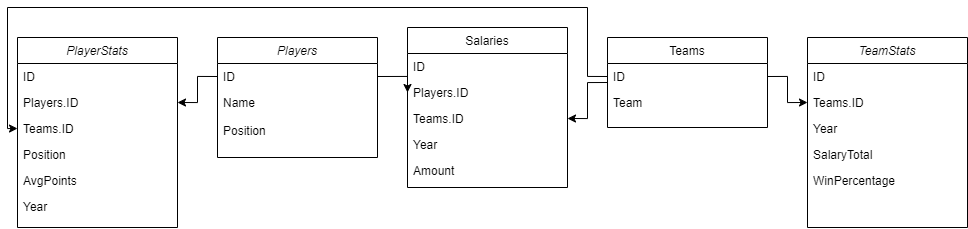

In [7]:
from IPython.display import Image
Image(filename='schema.png') 

#### Players
This table contains simply players' unique ID, name, and position. These are the only attributes which remain constant for a player every year.

#### Teams
This table contains a list of teams' unique ID and name. For teams whose identity has changed over this time period (for example, the Oakland Raiders became the Las Vegas Raiders), the 2021 team name is used.

#### Salaries
Each record in this table contains an observation about one player's earnings from one team over one year. This data will have to be converted from contract data using a simple algorithm.

#### PlayerStats
Each record in this table contains an observation about one player's average fantasy points per game on one team over one year. Not every salaried player will appear in this table; only players from certain positions who averaged over 0 fantasy points.

#### TeamStats
Each record in this table contains an observation about one team's total salary spending and win percentage over one year.

### Data Management step 1: Modifying DataFrames

In order to structure the collected data in a way that is consistent with my schema, I will first modify the pandas dataframes to prepare them to be exported into a sqlite database. I will now manually go through all instances where a player was designated as "Multi" for multiple teams.

In [8]:
multis = points[points["Team"] == "Multi"]
print("Number of players with 'Multi' team designation: " + str(multis.shape[0]))

Number of players with 'Multi' team designation: 477


Oh, man. As commonly found in data processing, there are way too many edge cases for me to handle manually. Since I can't analyze the intricacies of all 477 player trades and contract negotiations, I will throw away all of the "Multi" designated players that averaged less than 10 fantasy points that year.

In [9]:
points = points[(points["Team"] != "Multi") | (points["Avg"] >= 10)]
# Now with underperforming "Multi" players removed, check how many must be manually updated.
multis = points[points["Team"] == "Multi"]
print("Number of players with 'Multi' team designation: " + str(multis.shape[0]))
multis

Number of players with 'Multi' team designation: 17


,Player,Team,Position,Avg,Year
56,Harrison Butker,Multi,K,12.3,2017
180,Jimmy Garoppolo,Multi,QB,14.5,2017
24,Navorro Bowman,Multi,LB,13.1,2017
272,Byron Maxwell,Multi,CB,10.0,2017
297,Zach Vigil,Multi,LB,12.0,2017
564,James Harrison,Multi,LB,15.8,2017
697,Keith Reaser,Multi,CB,13.0,2017
414,Matt Barkley,Multi,QB,17.1,2018
55,Ha Ha Clinton-Dix,Multi,S,10.7,2018
59,Kenyan Drake,Multi,RB,11.7,2019


This is much more workable. I will do some research and update these cells with a singular team below. If a player played for two teams an almost-equal amount, I will choose the team for whom he played more games.

In [10]:
points.at[56, "Team"] = "KC"
points.at[180, "Team"] = "SF"
points.at[24, "Team"] = "LV"
points.at[272, "Team"] = "SEA"
points.at[297, "Team"] = "WAS"
points.at[564, "Team"] = "NE"
points.at[697, "Team"] = "KC"
points.at[414, "Team"] = "BUF"
points.at[55, "Team"] = "WAS"
points.at[59, "Team"] = "ARI"
points.at[174, "Team"] = "ATL"
points.at[248, "Team"] = "DET"
points.at[271, "Team"] = "DAL"
points.at[533, "Team"] = "IND"
points.at[57, "Team"] = "PIT"
points.at[187, "Team"] = "NYJ"
points.at[296, "Team"] = "NYJ"

Next I will go over some other inconsistencies in the data. From skimming the data, I see that some players are tagged as playing for "OAK" (the Oakland Raiders) which are now called the Las Vegas Raiders (LV), and some players are marked as team FA (Free Agent). There are only three Free Agents, only one of which (Patrick Surtain II) had any impact on his team. I will update the cells accordingly, removing the other two FAs.

In [11]:
points = points.replace("OAK", "LV")
points.at[662, "Team"] = "DEN"
points = points[points["Team"] != "FA"]

Lastly, I will modify the teams in the Contracts and Wins dataframes to be consistent with these abbreviations.

In [12]:
abbrevs = {
    "Arizona" : "ARI",
    "Atlanta" : "ATL",
    "Baltimore" : "BAL",
    "Buffalo" : "BUF",
    "Carolina" : "CAR",
    "Chicago" : "CHI",
    "Cincinnati" : "CIN",
    "Cleveland" : "CLE",
    "Dallas" : "DAL",
    "Denver" : "DEN",
    "Detroit" : "DET",
    "Green Bay" : "GB",
    "Houston" : "HOU",
    "Indianapolis" : "IND",
    "Jacksonville" : "JAC",
    "Kansas City" : "KC",
    "Miami" : "MIA",
    "Minnesota" : "MIN",
    "New England" : "NE",
    "New Orleans" : "NO",
    "NY Giants" : "NYG",
    "NY Jets" : "NYJ",
    "Las Vegas" : "LV",
    "Philadelphia" : "PHI",
    "Pittsburgh" : "PIT",
    "LA Chargers" : "LAC",
    "San Francisco" : "SF",
    "Seattle" : "SEA",
    "LA Rams" : "LAR",
    "Tampa Bay" : "TB",
    "Tennessee" : "TEN",
    "Washington" : "WAS"
}

for (full, abbrev) in abbrevs.items():
    wins = wins.replace(full, abbrev)

abbrevsSal = {
    "Saints" : "NO",
    "Packers": "GB",
    "Bills": "BUF",
    "Bengals": "CIN",
    "Cardinals": "ARI",
    "Panthers": "CAR",
    "Texans": "HOU",
    "Seahawks": "SEA",
    "Jaguars": "JAC",
    "Cowboys": "DAL",
    "Browns": "CLE",
    "Dolphins": "MIA",
    "Vikings": "MIN",
    "Jets": "NYJ",
    "Broncos": "DEN",
    "Chargers": "LAC",
    "Steelers": "PIT",
    "Chiefs": "KC",
    "Commanders": "WAS",
    "Eagles": "PHI",
    "Colts": "IND",
    "Lions": "DET",
    "Falcons": "ATL",
    "Rams": "LAR",
    "Buccaneers": "TB",
    "Giants": "NYG",
    "Bears": "CHI",
    "49ers": "SF",
    "Raiders": "LV",
    "Ravens" : "BAL",
    "Patriots": "NE",
    "Titans": "TEN" 
}

for (full, abbrev) in abbrevsSal.items():
    contracts = contracts.replace(full, abbrev)
    
# The line below removes the other teams who the player played for, but did not receive significant payment from.
contracts['Team'] = contracts['Team'].map(lambda x: x[:3].replace("/", ""))

contracts = contracts.replace("JAX", "JAC") # Fixing bug where "JAX" was already in the Team field

### Data Management step 2: Loading into SQLite

The first step in building the sqlite database is to draw the layout of each table.

In [13]:
import sqlite3
conn = sqlite3.connect("data.db")
cur = conn.cursor()

cur.execute('''
CREATE TABLE IF NOT EXISTS Teams (
id INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT UNIQUE,
Team TEXT UNIQUE
)''')

cur.execute('''
CREATE TABLE IF NOT EXISTS Players (
id INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT UNIQUE,
std TEXT UNIQUE,
full_name TEXT,
Position TEXT
)''')

cur.execute('''
CREATE TABLE IF NOT EXISTS Salaries (
id INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT UNIQUE,
player_id INTEGER NOT NULL,
team_id INTEGER NOT NULL,
Year INTEGER NOT NULL,
Amount INTEGER NOT NULL
)''')

cur.execute('''
CREATE TABLE IF NOT EXISTS Team_stats (
id INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT UNIQUE,
team_id INTEGER NOT NULL,
Year INTEGER NOT NULL,
salary_total INTEGER NOT NULL,
win_percentage INTEGER NOT NULL
)''')

cur.execute('''
CREATE TABLE IF NOT EXISTS Player_stats (
id INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT UNIQUE,
player_id INTEGER NUT NULL,
team_id INTEGER NOT NULL,
Position INTEGER NOT NULL,
Avg INTEGER NOT NULL,
Year INTEGER NOT NULL
)''')

First I will tackle the Teams table. I will create a dataframe of unique teams using the wins dataframe. Then I will load this into the sqlite database using pandas' built-in to_sql() method.

In [14]:
team_ids = wins.drop_duplicates("Team")["Team"]
#print(team_ids)
team_ids.to_sql("Teams", conn, if_exists="append", index=False) # Allowing sqlite to automatically populate the ID field

The next step is to compile a unique list of players for the Players table. One issue with this is that certain players will appear more than once due to their name being spelled differently in the Contracts and Points dataframes. Example: "D.J. Moore" in the Contracts dataframe is listed as "DJ Moore" (no periods) in the Points dataframe. I need to reconcile this difference in order to link players' points to their earnings. I will do this by creating a method that removes common inconsistencies in names, created a "standardized" name that is more reliable. Some examples of standardized player names are below.

In [15]:
import re
def std(string):
    string = string.replace(" III", "").replace(" II", "").replace(" IV", "").replace(" Jr.", "").replace(" Sr.", "").replace("Scott Miller", "Scotty Miller")
    string = string.replace("Joshua", "Josh").replace("Michael", "Mike").replace("Matthew", "Matt").replace("William", "Will")
    string = string.replace("Benjamin", "Ben").replace("Patrick", "Pat").replace("Timothy", "Tim").replace("Nathan", "Nate")
    string = string.replace("Cameron", "Cam").replace("Christopher", "Chris")
    expr = re.compile(" V$")
    string = expr.sub("", string)
    expr = re.compile('[^a-zA-Z]')
    return expr.sub('', string).lower()

contracts["std"] = contracts["Player"].map(std)
points["std"] = points["Player"].map(std)

points[["Player", "std"]].sample(5)

,Player,std
444,Jaquiski Tartt,jaquiskitartt
393,DeMarcus Walker,demarcuswalker
345,Jimmy Graham,jimmygraham
631,Myles Bryant,mylesbryant
309,Erik Walden,erikwalden


I already know that there are far more salaried players than players who recorded fantasy points. The trouble is how many players either:
1. Do not have contract data recorded in the contracts table
2. Slipped past the std() filter with an uncommon name

In [16]:
uniquePlayersInContracts = list(set(contracts["std"].tolist()))
print("Number of unique players in contracts dataframe: " + str(len(uniquePlayersInContracts)))

uniquePlayersInPoints = list(set(points["std"].tolist()))
print("Number of unique players in points dataframe: " + str(len(uniquePlayersInPoints)))

i = 0
for index, row in points.iterrows():
    if row["std"] not in uniquePlayersInContracts:
        #print(row["Player"], row["Year"])
        i+= 1
        
print("Total number of players missing if I use contracts table for names: " + str(i))

Number of unique players in contracts dataframe: 8033
Number of unique players in points dataframe: 2681
Total number of players missing if I use contracts table for names: 53


I could impute/standardize the salary data for these 53 players, but since this is only 0.5% of salaried players, the impact on accuracy is probably not worth the effort that it would take. I will leave their contract data missing, most likely with little impact on my analysis. I will add all players from contracts to a unique Players dataframe, then add all the missing players from the points dataframe afterward. I will include a "full_name" field that displays the player's unstandardized name from the original source dataframe.

In [17]:
names = list()
players = pd.DataFrame(columns=["std", "full_name", "Position"])
for (index, row) in contracts.iterrows():
    std_name = row["std"]
    full_name = row["Player"]
    position = row["Position"]
    if std_name not in names:
        names.append(std_name)
        players = players.append({"std" : std_name, "full_name" : full_name, "Position" : position}, ignore_index=True)

for (index, row) in points.iterrows():
    std_name = row["std"]
    full_name = row["Player"]
    position = row["Position"]
    if std_name not in names:
        names.append(std_name)
        players = players.append({"std" : std_name, "full_name" : full_name, "Position" : position}, ignore_index=True)        

print("Number of players: " + str(len(players)))
players.sample(5)

Number of players: 8056


,std,full_name,Position
2649,tyreemayfield,Tyree Mayfield,TE
6183,koafarmer,Koa Farmer,LB
1391,isaiahford,Isaiah Ford,WR
1987,joshcrockett,Josh Crockett,WR
4046,calaiscampbell,Calais Campbell,DT


Finally, I can add the player names to the database.

In [18]:
players.to_sql("Players", conn, if_exists="append", index=False) # Allowing sqlite to automatically populate the ID field

The next step in modifying the dataframes is to convert the contract data into yearly salary data. This will be done by duplicating a player's APY salary (average money made per year) across the specified years of the salary. For example, if my contract has an APY of \\$3 million, a length of 4 years, and it was signed in 2015, then I will create 4 observations denoting pay of \\$3 million in 2015, 2016, 2017, and 2018.

Because this is such a fundamental reworking of the dataframe, I wil create a new dataframe and load new records into it as I go along. In order to determine the team that the player played for that year, I will first consult the points database to check what team they played for. If this does not exist, I will use the team in the contracts dataframe.

Another thing to consider is that, due to the way that contracts are handled in the real world, the spending totals will not be 100% accurate. A team's total payroll of its players is much more complex than summing the values of its player contracts. One side effect of this difference will be that many teams' spending will appear to reach far beyond the Salary Cap. However, a team's player-spending is linked closely enough with contract values that this metric should suffice for my analysis.

In [19]:
salaries = pd.DataFrame(columns=["player_id", "team_id", "Year", "Amount"])

for (index, row) in contracts.iterrows():
    # Obtain information from row
    std_name = std(row["Player"])
    team = row["Team"]
    signed = int(row["Year Signed"])
    years = int(row["Years"])
    apy = row["APY"]
    apy = int(apy.replace("$", "").replace(",", "")) # Ensuring APY is formatted as an integer
    
    # Find player id from Players table based on standardized name
    cur.execute("SELECT id, std FROM Players WHERE std = ?", (std_name, ))
    player_id = cur.fetchone()[0]
    
    # Find team id from Teams table based on team abbreviation
    cur.execute("SELECT id FROM Teams WHERE Team = ?", (team, ))
    team_id = cur.fetchone()[0]
    
    for year in range(signed, (signed+years)):
        data = {"player_id" : player_id, "team_id" : team_id, "Year" : year, "Amount" : apy}
        salaries = salaries.append(data, ignore_index=True)

In [20]:
salaries = salaries[(salaries["Year"] >= 2017) & (salaries["Year"] <= 2021)] # Removing all salary data out of range
print("Number of player salaries: " + str(len(salaries)))
salaries.sample(5)

Number of player salaries: 34471


,player_id,team_id,Year,Amount
7222,1122,17,2021,7250000
54637,7941,25,2018,915000
25948,3861,6,2017,992505
32075,4426,4,2020,510000
35709,5297,30,2021,669402


In the above sample we see the format of the salaries dataframe. It has a player_id which refers to a player in the Players table, and a team_id which refers to a team in the Teams table. Each row represents an observation on how much money a player made for a certain team during a certain year. It is now in the correct format according to the schema for the database, so I will load it into the Salaries table. 

In [21]:
salaries.to_sql("Salaries", conn, if_exists="append", index=False) # Allowing sqlite to automatically populate the ID field

Now that we have the Players, Teams, and Salaries tables, I will now turn to the TeamStats table. This is simply the current wins dataframe, with an extra column showing how much that team spent on player salaries for that year. This amount, called the Salary Total, will be calulated using the sum() function in SQL.

In [22]:
salary_query = "SELECT Salaries.team_id, Teams.Team, Salaries.Year, sum(Amount) as salary_total FROM Salaries INNER JOIN Teams ON Salaries.team_id = Teams.id GROUP BY Salaries.Year, Salaries.team_id"
salary_totals = pd.read_sql(salary_query, conn)
print("Number of rows retrieved: " + str(len(salary_totals)))
salary_totals.sample(5)

Number of rows retrieved: 160


,team_id,Team,Year,salary_total
36,5,NO,2018,293720801
97,2,NE,2020,281000132
125,30,IND,2020,322976909
13,14,LAC,2017,250721477
26,27,DEN,2017,253963543


The above sample shows a few teams' total spending for one year. Note that there is exactly 160 rows (32 teams * 5 years). This matches up with the wins dataframe so that I can add that team's win percentage for that year. I will do this now using an inner join on team name and year.

In [23]:
wins["Year"] = pd.to_numeric(wins["Year"]) # Ensuring win years are integers so they can be joined with salary_totals
teamStats = salary_totals.merge(wins, on=["Team", "Year"])
print("Number of rows in dataframe: " + str(len(teamStats)))
teamStats.sample(5)

Number of rows in dataframe: 160


,team_id,Team,Year,salary_total,Win %
122,27,DEN,2020,295984114,31.3%
89,26,CHI,2019,350852689,50.0%
67,4,PIT,2019,288296375,50.0%
124,29,HOU,2020,356940410,25.0%
15,16,TEN,2017,242101562,55.6%


Now the teamStats dataframe is in the proper format for loading into the database.

In [24]:
teamStats = teamStats.drop("Team", axis=1).rename({"Win %" : "win_percentage"}, axis=1)
teamStats.head()
teamStats.to_sql("Team_stats", conn, if_exists="append", index=False) # Allowing sqlite to automatically populate the ID field

Lastly I will create the Player_stats table. This is just the points dataframe with some modifications to include foreign keys.

In [25]:
playerStats = pd.DataFrame(columns=["player_id", "team_id", "Position", "Avg", "Year"])
for (index, row) in points.iterrows():
    # Get data from row in points dataframe
    std_name = row["std"]
    team_name = row["Team"]
    position = row["Position"]
    avg = float(row["Avg"])
    year = int(row["Year"])
    
    # Get id from Players table based on standardized name
    cur.execute("SELECT id FROM Players WHERE std = ?", (std_name, ))
    player_id = cur.fetchone()[0]
    
    # Find team id from Teams table based on team abbreviation
    cur.execute("SELECT id FROM Teams WHERE Team = ?", (team_name, ))
    team_id = cur.fetchone()[0]
    
    data = {"player_id" : player_id, "team_id" : team_id, "Position" : position, "Avg": avg, "Year": year}
    playerStats = playerStats.append(data, ignore_index=True)
playerStats.to_sql("Player_stats", conn, if_exists="append", index=False) # Allowing sqlite to automatically populate ID

I now have a sqlite database that is consistent with the schema shown earlier. It is time to do some analysis.

## Exploratory Analysis

I will begin the exploratory analysis by simply examining teams' spending over the five year period. If team spending has changed drastically over the last five years, I will have to account for this in my hypothesis testing. I will examine team spending over time via a scatterplot and a violin plot.

### Part 1: Team spending vs. time

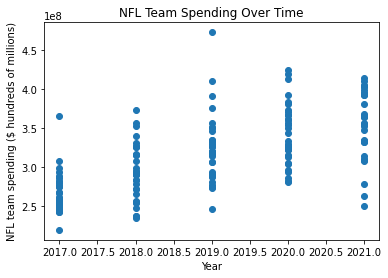

In [26]:
# Plotting team spending vs. time
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.set_xlabel("Year")
ax.set_ylabel("NFL team spending ($ hundreds of millions)")
ax.set_title("NFL Team Spending Over Time")
ax.scatter(teamStats["Year"], teamStats["salary_total"])

Note: These are not the exact amounts of money that NFL teams awarded players for these years. Instead, I am using a summation of contract values for each year. These values are directly proportional to players' actual earnings, but are higher than the actual values. This leads to the appearance that many teams are spending more than the most recent salary cap of \\$200 million mentioned earlier. 

Text(0.5, 1.0, 'NFL Team Spending Distributions by Year')

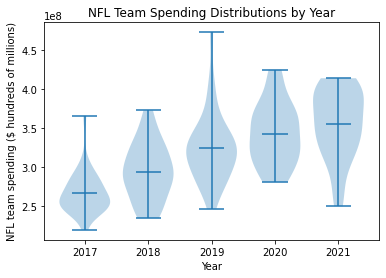

In [27]:
spending_per_year = list()
for year in range(2017,2021+1):
    totals = teamStats[teamStats["Year"] == year]["salary_total"]
    spending_per_year.append(totals)
years = list(range(2017, 2021+1))

fig, ax = plt.subplots()
ax.violinplot(spending_per_year,years,widths=0.8,showmeans=True)
ax.set_xlabel("Year")
ax.set_ylabel("NFL team spending ($ hundreds of millions)")
ax.set_title("NFL Team Spending Distributions by Year")

From these plots, it is apparent that NFL teams' spending on players has increased over time. This assumption can be made from the fact that the mean spending has increased every year since 2017. This makes sense in line with the fact that [the NFL is bringing in more money every year.](https://www.statista.com/statistics/193457/total-league-revenue-of-the-nfl-since-2005/#) One thing to notice about these distributions is that the mode of the distribution has shifted. In years before 2020, the mode is below the average. However, in the last two years, the mode has moved above the average, as evidenced in the top-heavy violin plots in later years.

These distributions can be translated into actual NFL spending. In earlier years (2017-2019), there were a few teams spending much higher than the average, leading to the mean spending being higher than a large number of teams. In later years (2020-2021), there are fewer of these ultra-spenders. In fact, certain teams spent much less than the average, bringing the mean down lower than most of the values in 2021.

### Part 2: Team spending vs. wins

The next part of my exploration of the data will be to compare teams' spending and wins visually. I will start by using a scatterplot of all teams' spending versus wins.

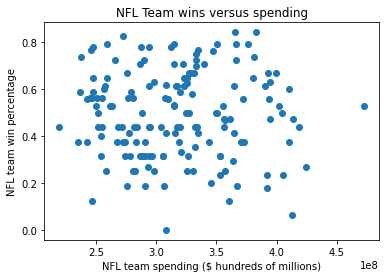

In [28]:
# Plotting team spending vs. wins
import numpy as np
fig, ax = plt.subplots()
ax.set_xlabel("NFL team spending ($ hundreds of millions)")
ax.set_ylabel("NFL team win percentage")
ax.set_title("NFL Team wins versus spending")
#ax.set_yticks(ax.get_yticks()[::5])
ax.scatter(teamStats["salary_total"], teamStats["win_percentage"].str.rstrip('%').astype('float') / 100.0)

The above scatterplot seems to imply that there is very little correlation between a team's total player spending and their win percentage. Let's break this down further by examining teams' spending by position, and compare this to a team's wins.

In [29]:
# This section gets a bit tricky with SQL querying. Even though it looks like I am using three different SELECT statements,
# I am really using multiple queries nested inside each other. The first variable, pos_query, retrieves the Salaries table,
# simply with the player's position included via the Players table. The second variable queries the result returned from
# the first query in order to group spending based on three different categories: the team, the position, and year.

# So, for example, the query would sum all salaries into one row for:
# ARI wide receivers in the year 2019
# IND quarterbacks in the year 2018
# PHI runningbacks in the year 2016
# ... and so on for every combination of team, position, and year

# And the final query simply adds on the team's win percentage for that year.
pos_query = "SELECT team_id, Players.Position, Year, Amount FROM Salaries JOIN Players ON Salaries.player_id = Players.id"
pos_query = "SELECT team_id, Position, Year, sum(Amount) as pos_total FROM (" + pos_query + ") GROUP BY team_id, Position, Year"

pos_query = "SELECT Teams.Team, first.Position, first.Year, first.pos_total, Team_stats.win_percentage FROM (" + pos_query + ") AS first JOIN Team_stats ON first.team_id = Team_stats.team_id AND first.Year = Team_stats.Year JOIN Teams on first.team_id = Teams.id"
teamWinsByPos = pd.read_sql(pos_query, conn)
print("Rows retrieved: " + str(len(teamWinsByPos)))
teamWinsByPos.head()

Rows retrieved: 2233


,Team,Position,Year,pos_total,win_percentage
0,PHI,CB,2017,26425197,84.2%
1,PHI,DE,2017,31523581,84.2%
2,PHI,DT,2017,48866056,84.2%
3,PHI,K,2017,510000,84.2%
4,PHI,LB,2017,19984921,84.2%


Theoretically, there should be 2,240 rows: there are 32 NFL teams which I divided into 14 positions over 5 years. I am missing seven rows, which are more than likely based on a missing salary for some team's long snapper in 2018 or something. It is not necessary to find/impute the 0.3% of missing data. I will now use this dataframe to plot team's spending on certain positions versus wins.

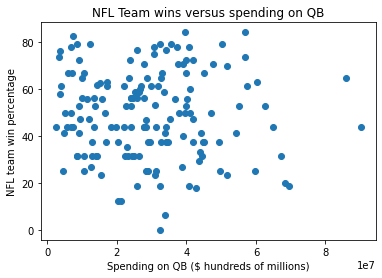

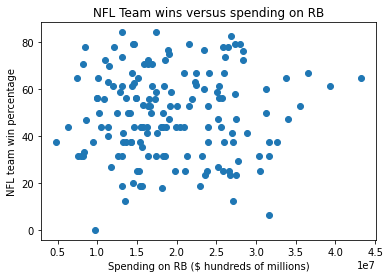

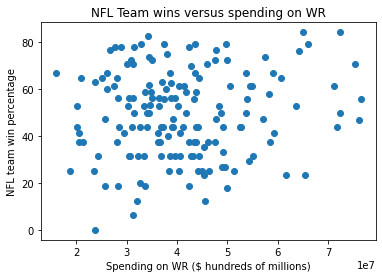

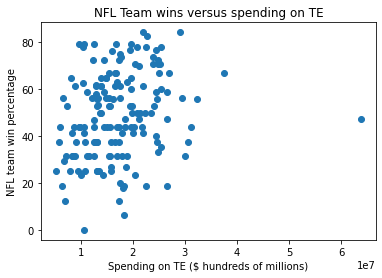

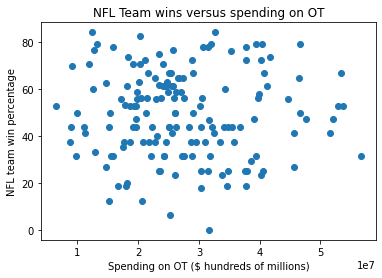

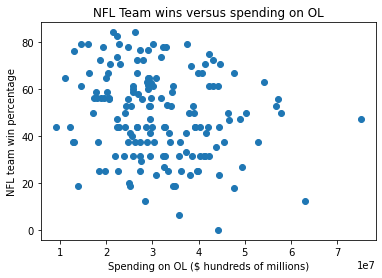

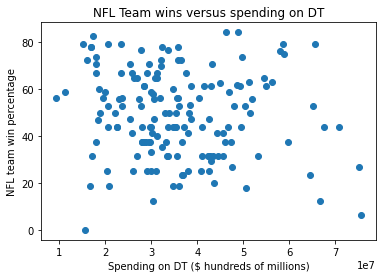

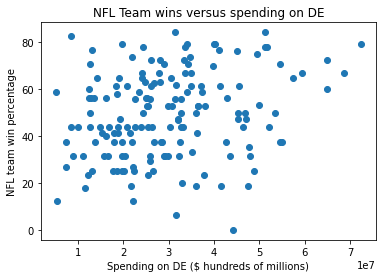

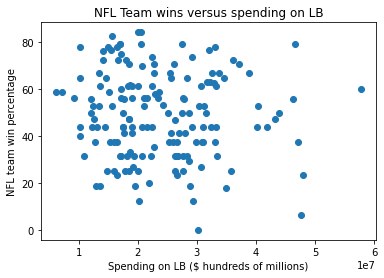

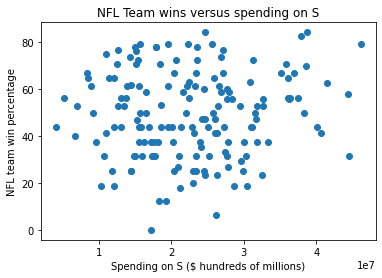

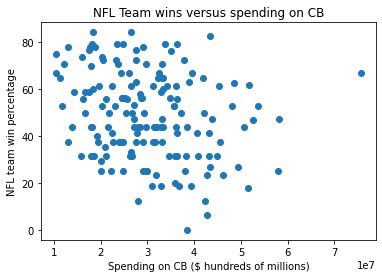

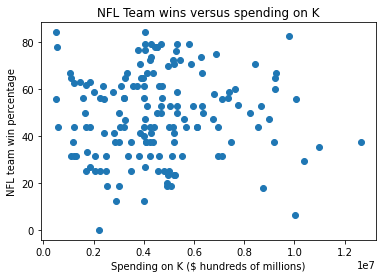

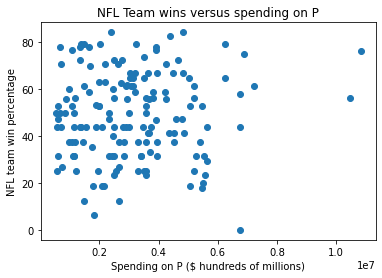

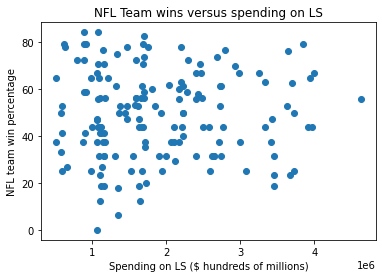

In [30]:
# Plotting spending vs. wins by position
positions = ["QB", "RB", "WR", "TE", "OT", "OL", "DT", "DE", "LB", "S", "CB", "K", "P", "LS"]
for pos in positions:
    data = teamWinsByPos[teamWinsByPos["Position"] == pos]
    spending = data["pos_total"]
    wins = data["win_percentage"].str.rstrip("%").astype(float)
    
    fig, ax = plt.subplots()
    ax.set_xlabel("Spending on " + pos + " ($ hundreds of millions)")
    ax.set_ylabel("NFL team win percentage")
    ax.set_title("NFL Team wins versus spending on " + pos)
    #ax.set_yticks(ax.get_yticks()[::5])
    ax.scatter(spending, wins)

From the above graphs, it is clear that the association between spending and wins varies widely depending on position. Most of the individual positions seem to have little correlation to wins, which is expected. Heavy spending on your punter is not likely to lead to wins. However, it seems plausible that certain positions may be slightly correlated with wins. RB, WR, and DE spending seem most likely to have a correlation to wins (yet even these positions seem to offer a weak correlation).

### Part 3: Player earnings vs. performance

Another aspect of the data we can look at is individual players' earnings against their performance that year. I will start with a plot of all players' performances against their salary for that year.

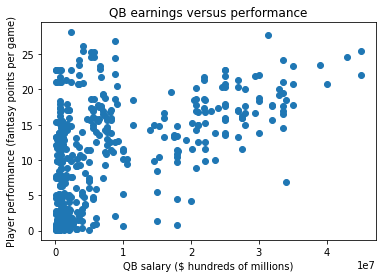

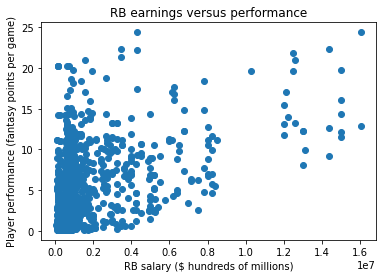

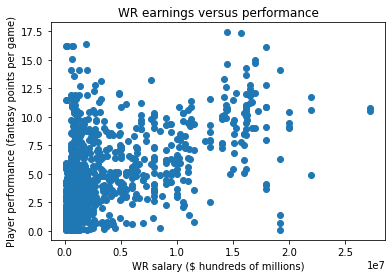

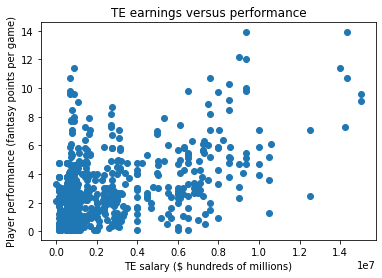

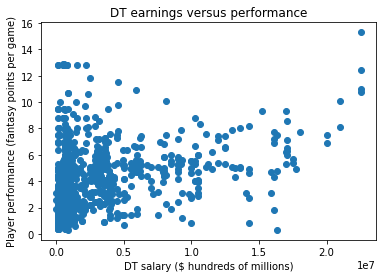

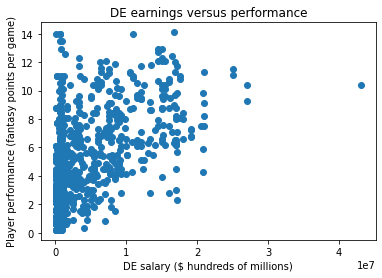

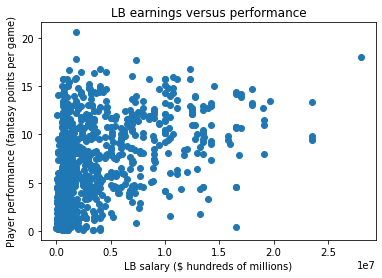

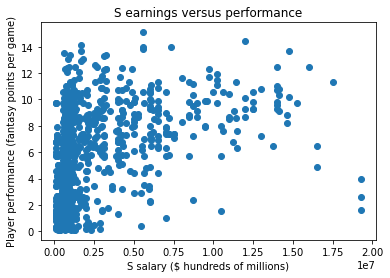

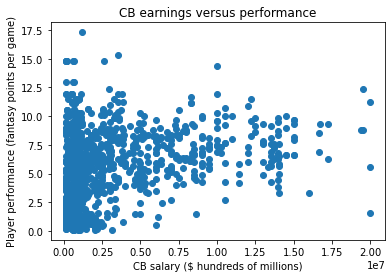

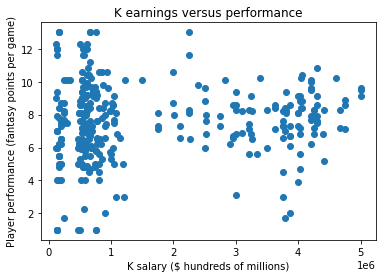

In [31]:
# Plotting player earnings vs. performance
# The below query simply retrieves the Player_stats table, but with the player's salary for that year included at the end.
player_query = "SELECT Player_stats.player_id, Player_stats.team_id, Player_stats.Position, Player_stats.Avg, Player_stats.Year, Salaries.Amount FROM Player_stats JOIN Salaries ON Player_stats.player_id = Salaries.player_id AND Player_stats.Year = Salaries.Year"
playerPerfBySal = pd.read_sql(player_query, conn)

positions = ["QB", "RB", "WR", "TE", "DT", "DE", "LB", "S", "CB", "K"]
for pos in positions:
    data = playerPerfBySal[playerPerfBySal["Position"] == pos]
    salary = data["Amount"]
    avg = data["Avg"]
    
    fig, ax = plt.subplots()
    ax.set_xlabel(pos + " salary ($ hundreds of millions)")
    ax.set_ylabel("Player performance (fantasy points per game)")
    ax.set_title(pos + " earnings versus performance")
    #ax.set_yticks(ax.get_yticks()[::5])
    ax.scatter(salary, avg)

Now there is a much clearer correlation at almost every position. However, based on the shape of the plots, it seems that a log transformation of the players' salaries would make for a much more accurate relationship. I will redo the graphs with this transformation before making any observations about the data.

C:\Users\brand\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


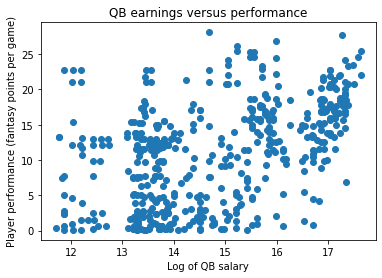

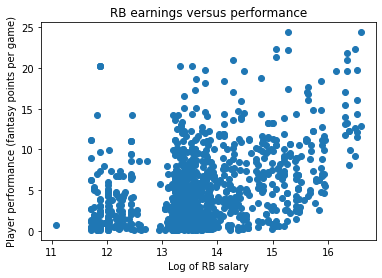

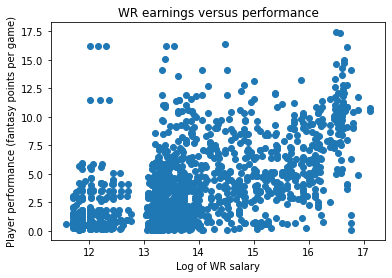

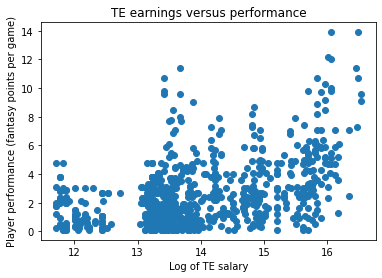

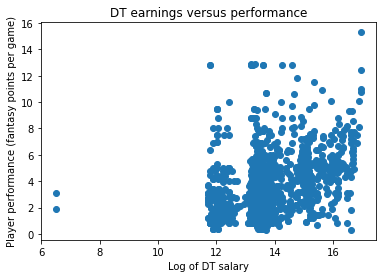

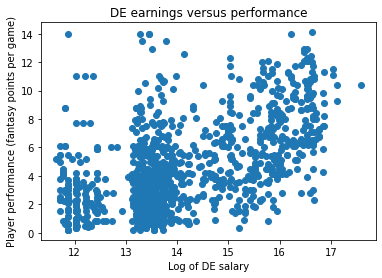

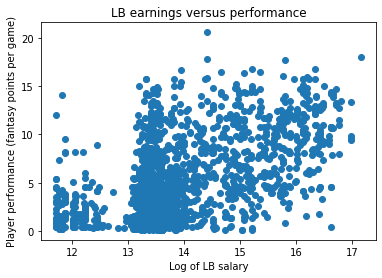

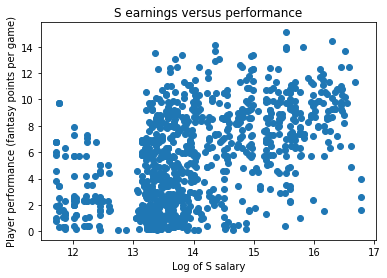

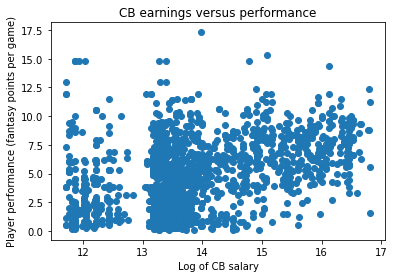

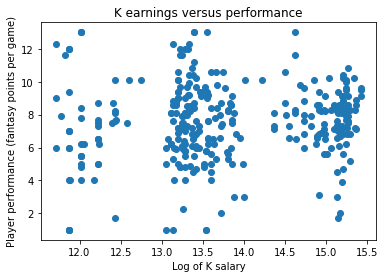

In [32]:
# Plotting log(player earnings) vs. performance
positions = ["QB", "RB", "WR", "TE", "DT", "DE", "LB", "S", "CB", "K"]
for pos in positions:
    data = playerPerfBySal[playerPerfBySal["Position"] == pos]
    salary = np.log(data["Amount"])
    avg = data["Avg"]
    
    fig, ax = plt.subplots()
    ax.set_xlabel("Log of " + pos + " salary")
    ax.set_ylabel("Player performance (fantasy points per game)")
    ax.set_title(pos + " earnings versus performance")
    #ax.set_yticks(ax.get_yticks()[::5])
    ax.scatter(salary, avg)

With the datapoints more evenly spread around the plot, the existence (or lack) of a correlation becomes much clearer. It is safe to say that DT, LB, CB, and K performances are not correlated with their salaries. However, the other positions have a correlation that may be anywhere from weak to strong: QB, RB, WR, TE, DE, and S all seem to have some kind of link between a player's earnings and their individual performance. Surprisingly, the relationship between a QB's salary and performance seems very weak if not missing.

I have now explored the data by plotting the distributions and relationships between several different categories of variables. I have formed some hypotheses about the data which I will now test using linear regression.

## Hypothesis Testing

As stated, I will be using linear regression to test correlations between spending and success, at both individual and team-wide levels. Since I have already shown every graph between all the relationships I will be testing, it is not necessary to draw each of the dozens of regression models graphically. Instead, I will test the validity of the model at a surface-level using R-squared and p values. For more information on how these metrics represent the usefulness of a model, see [this article.](https://rcompanion.org/handbook/G_10.html) If any model demonstrates a correlation, I will dive further to test if the model is truly reliable (for example, by verifying some of the assumptions behind linear regression).

### Part 1: Spending vs team wins by position

First, I will use machine learning to generate a linear regression model for every team's spending on a every position vs. their win percentage during that season. I will output the R-squared and p-value for every team/position and inspect the results to see if the null hypothesis (that is, that there is no relationship between any variable) can be rejected.

Instead of the popular scikit-learn library, I will be using scipy's linregress function because this makes it easy to find the metrics I am looking for.

In [33]:
from scipy.stats import linregress

# Testing spending vs. wins by position
positions = ["QB", "RB", "WR", "TE", "OT", "OL", "DT", "DE", "LB", "S", "CB", "K", "P", "LS"]
for pos in positions:
    data = teamWinsByPos[teamWinsByPos["Position"] == pos]
    spending = data["pos_total"]
    wins = data["win_percentage"].str.rstrip("%").astype(float)

    slope, intercept, r_value, p_value, std_err = linregress(spending, wins)
   
    r_squared = r_value**2
    if (r_squared > 0.3) or (p_value < 0.05): print("********")
    print("Position: " + pos)
    print("R-squared: " + str(r_squared))
    print("p value: " + str(p_value) + "\n")

Position: QB
R-squared: 0.0025047436988302647
p value: 0.5296858149147545

Position: RB
R-squared: 0.0007494215232977647
p value: 0.7311276443166554

Position: WR
R-squared: 0.01110259027066891
p value: 0.18481774238789453

********
Position: TE
R-squared: 0.04896831371286081
p value: 0.004921967727671471

Position: OT
R-squared: 0.00012096047296836644
p value: 0.8902160135906781

********
Position: OL
R-squared: 0.03856440703704457
p value: 0.012816901396770795

Position: DT
R-squared: 0.017416252996855914
p value: 0.09621104811582255

********
Position: DE
R-squared: 0.05890740466835326
p value: 0.0019857988347262746

Position: LB
R-squared: 0.006531740437861346
p value: 0.30965878234029454

Position: S
R-squared: 0.005681864782101506
p value: 0.3434659559421269

********
Position: CB
R-squared: 0.05774986304038592
p value: 0.002206854471050405

Position: K
R-squared: 0.0009760700190258704
p value: 0.6958450915454828

Position: P
R-squared: 0.0033330519268535597
p value: 0.4740667373

From the results above, there are only 4 models that have a significant relationship between spending at that position and a team's wins. Of these four models (or any model for that matter), none of them have an R-squared value above just 6%. That is, no more than 6% of the variance in a team's wins is explained by that team's spending on any given position. __There is not sufficient evidence to reject the null hypothesis that spending on a certain postion is correlated with a team's wins.__ 

### Part 2: Player performance vs. Salary by position

Now I will again use linear regression in order to test the null hypothesis that there is no correlation between player's performance and (the natural logarithm of) their salary. Like before, I will use R-squared and p values to do a preliminary check for any useful models. I will split up models by position similar to part 1.

In [34]:
from scipy.stats import linregress

# Testing log(earnings) vs. performance by position
playerPerfBySal = playerPerfBySal.dropna()
playerPerfBySal = playerPerfBySal[playerPerfBySal["Amount"] != 0] # Fixes bug. A $0 contract has no natural log

positions = ["QB", "RB", "WR", "TE", "DT", "DE", "LB", "S", "CB", "K"]
for pos in positions:
    data = playerPerfBySal[playerPerfBySal["Position"] == pos]
    salary = np.log(data["Amount"])
    avg = data["Avg"]
    slope, intercept, r_value, p_value, std_err = linregress(salary, avg)
   
    r_squared = r_value**2
    if (r_squared > 0.3) or (p_value < 0.05): print("********")
    print("Position: " + pos)
    print("R-squared: " + str(r_squared))
    print("p value: " + str(p_value) + "\n")

********
Position: QB
R-squared: 0.22032896123022244
p value: 5.335926083844802e-28

********
Position: RB
R-squared: 0.17226349726902115
p value: 9.166609042102493e-50

********
Position: WR
R-squared: 0.31981596710550214
p value: 8.995499683318153e-141

********
Position: TE
R-squared: 0.217354033313978
p value: 1.908066831939659e-46

********
Position: DT
R-squared: 0.1295361225486978
p value: 3.183663400642359e-40

********
Position: DE
R-squared: 0.2961541697776992
p value: 8.359266144647646e-88

********
Position: LB
R-squared: 0.28743015729064464
p value: 1.2434145645668792e-120

********
Position: S
R-squared: 0.2522544764333994
p value: 1.9354252624609483e-63

********
Position: CB
R-squared: 0.13956837140329553
p value: 6.220821927834724e-54

Position: K
R-squared: 0.006545040599085588
p value: 0.13891384450528424



These models appear much more useful than those in part 1. All models are significant at a 5% level except for K. Three stand out as the most significant. They are, in order of smallest p-value: WR, LB, and DE. I will investigate these three models further in order to see if these models are appropriate.

For each model, I will generate three plots. Listed below each plot is an assumption behind linear regression that the plot will help me to verify.
- Residuals vs. fitted values
    - This will allow me to test if the data is linear and has equal spread across the board.
    
- Histogram of residuals
    - This will allow me to ensure the residuals follow a normal distribution.
    
- Residual plot vs. index
    - This will allow me to ensure that the order of the values in the table does not affect the model's success.

In order to generate these plots more easily, I will write a few methods that allows me to find the residuals/fitted values of a model, and generate the diagnostic plots associated with those residuals.

In [35]:
# Returns the residuals and fitted values for an x and y dataset. These are linked by their index in the list.
def calc_residuals(x, y):
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    resids = list()
    fitteds = list()
    for (xval, yval) in dict(zip(x, y)).items():
        fitted = intercept + slope*xval
        resid = yval - fitted
        resids.append(resid)
        fitteds.append(fitted)
    return (resids, fitteds)

# Takes a plt axis, the residuals, and fitted values. Plots the residuals against the fitted values, and adds it to the
# paramaterized axis. This approach is helpful because I will want to display this as a subplot of a matrix.
# Also adds in a helpful red line to show the target value of 0.
def plot_residuals_fitted(ax, resids, fitteds):
    # Plotting the residuals
    #plt.subplots(figsize=(12, 6))
    #ax = plt.subplot(111)  # To remove spines
    ax.axhline(y=0, color='r', linestyle='-')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.title.set_text('Residuals vs. Fitted values')
    ax.scatter(x=fitteds, y=resids, alpha=0.5)

# Plots a histogram of residuals, and adds it to the axis passed in.
def plot_hist_resids(ax, resids):
    ax.title.set_text("Histogram of residuals")
    ax.hist(resids)

# Plots the residuals against their order as they are presented in the data. Adds this to the axis passed in.
def plot_resids_order(ax, resids):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.title.set_text('Residuals vs. order')
    ax.scatter(x=resids, y=list(range(len(resids))), alpha=0.5)
    

Now that I have these helpful methods, I can get to work generating diagnostic plots for the models that seem the most significant: WR, DE, and LB. For each position, I will create a 2x2 matrix of subplots, and add each diagnostic plot to this matrix.

Position: WR


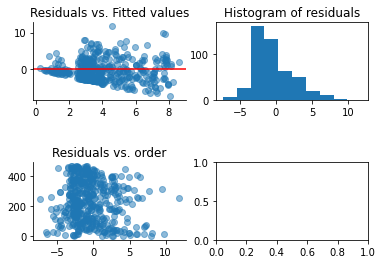



Position: DE


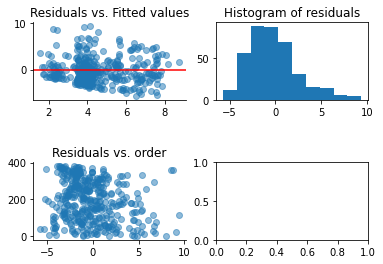



Position: LB


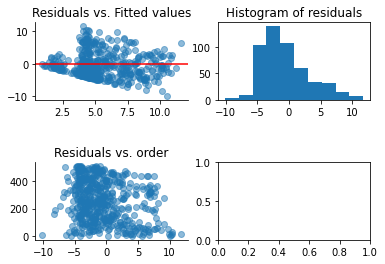

In [36]:
from scipy.stats import linregress

# Testing log(earnings) vs. performance by position
def get_index(i):
    if i == 0: return 0,0
    if i == 1: return 0,1
    if i == 2: return 1,0
    else: return 1,1
    
positions = ["WR", "DE", "LB"]
for pos in positions:
    print("Position: " + pos)
    fig, ax = plt.subplots(2, 2)
    plt.subplots_adjust(hspace=0.8)
    data = playerPerfBySal[playerPerfBySal["Position"] == pos]
    salary = np.log(data["Amount"])
    avg = data["Avg"]
    resids, fitteds = calc_residuals(salary, avg)
    plot_residuals_fitted(ax[0, 0], resids, fitteds)
    
    plot_hist_resids(ax[0, 1], resids)
    
    plot_resids_order(ax[1, 0], resids)
    
    plt.show()
    print("\n")

First, the residuals vs. fitted values should theoretically demonstrate constant spread, centered around the red line at residual = 0. Unfortunately this is not the case, as at every position there is a fanning out of the residuals as fitted values increase. The histograms of the residuals appear to be normally distributed with a mean of 0, which means that the normality assumption is satisfied. Lastly, the residuals vs. order plots are mixed. The WR plot appears to have a slight pattern, but the rest seem to not have any pattern, which means the independence of errors assumption is likely satsifed for all except WRs.

One way to possibly fix the issue of non-constant spread is to transform the response using a natural logarithm. I already tried this with the salary amounts, but hopefully transforming the response will fix this assumption violation.

Position: WR


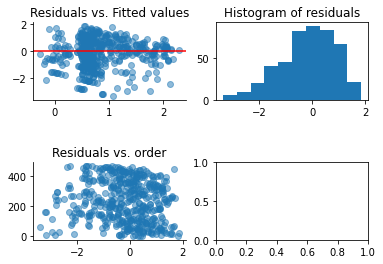



Position: DE


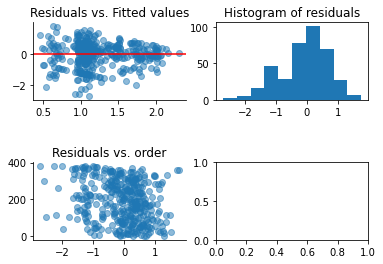



Position: LB


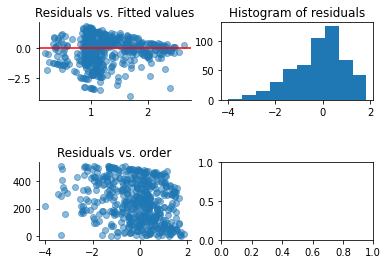

In [37]:
from scipy.stats import linregress

# Testing log(earnings) vs. performance by position
def get_index(i):
    if i == 0: return 0,0
    if i == 1: return 0,1
    if i == 2: return 1,0
    else: return 1,1
    
positions = ["WR", "DE", "LB"]
for pos in positions:
    print("Position: " + pos)
    fig, ax = plt.subplots(2, 2)
    plt.subplots_adjust(hspace=0.8)
    data = playerPerfBySal[playerPerfBySal["Position"] == pos]
    salary = np.log(data["Amount"])
    avg = np.log(data["Avg"])
    resids, fitteds = calc_residuals(salary, avg)
    plot_residuals_fitted(ax[0, 0], resids, fitteds)
    
    plot_hist_resids(ax[0, 1], resids)
    
    plot_resids_order(ax[1, 0], resids)
    
    plt.show()
    print("\n")

This is much better. The residuals vs. fitted value plots for all positions seem to be much improved. They are not perfect (LB's residuals have greater variance in the middle, for example). However, they have been brought to at least an acceptable level as far as the assumptions are concered. The residuals vs. order plots now have no discernible pattern at any position, and the residuals have remained normally distributed according to the histograms.

For clarity, these are the models generated for these positions:

In [38]:
positions = ["WR", "DE", "LB"]
for pos in positions:
    data = playerPerfBySal[playerPerfBySal["Position"] == pos]
    salary = np.log(data["Amount"])
    avg = np.log(data["Avg"])

    slope, intercept, r_value, p_value, std_err = linregress(salary, avg)
    #intercept = round(intercept, 3)
    #print("Model: Fantasy points per game = e^(" + str(intercept) + " + " + str(slope) + " * ln(salary))")

Position: WR
    
Fantasy points per game = $e^{-5.605 + 0.461 * ln(salary)}$

Position: DE
    
Fantasy points per game = $e^{-3.164 + 0.311 * ln(salary)}$

Position: LB
    
Fantasy points per game = $e^{-5.130 + 0.453 * ln(salary)}$

Due to main assumptions behind linear regression being met, and the significance implied by hypothesis testing, it is possible to reject the null hypothesis of no correlation between salary and player performance among WRs, DEs, and LBs. __There is evidence that higher-paid players at these positions perform better__.

## Insights Attained

From the exploratory analysis and hypothesis testing of the data, there are several key takeaways that can be drawn. The first idea is that paying a player more money is generally associated with better performance from that player, at most positions in football.

The second takeaway is that a few positions - namely WR, LB, and DE - have stronger correlations between performance and pay. This is probably explained by the influential role that [WRs](https://www.washingtonpost.com/sports/2022/04/25/wide-receivers-nfl-salary/) and [pass rushers](https://bleacherreport.com/articles/1251690-why-defensive-end-is-the-second-most-important-position-in-the-nfl) have in today's game. Highly-skilled players at these positions can turn a struggling team around, perhaps more so than players at other positions. As a result, the best of these players carry a premium that is reflected in their performance.

Whether this payment causes high performance or the opposite is true is up for debate. Most likely, a player's performance on the field is not spurred on by his thoughts of a paycheck. Rather than argue this point, this analysis is meant to explore if spending large amounts of money on NFL players is statistically worth it. According to the data, the answer seems to be... kind of.

It is clear that highly-paid players generally perform better than their lower-paid counterparts. However, the data also suggests that this spending, even focused on certain positions, is not correlated with a team actually winning. So what gives? 

I believe there are numerous reasons why this is, and they all come down to this: __A team's success on the field depends on far more than the performance of individual players__. This conclusion is supported by the data. It is also supported by the nature of the game.

When it comes to team-wide success, there are a variety of factors that have contributed in the past: coaching, playcalling, drafting, and player development to name a few. But the NFL muddles things even further by shrinking the sample size of games played (a necessity due to the physical and explosive nature of the sport). There is only 60 minutes of playing time per game, and only 16 or 17 games in a season. This is much less than the playing time used by other sports organizations like the MLB and NBA (who can play longer/more often due to their less physical nature). This results in NFL win rates across just one season being [notoriously difficult to predict.](https://www.usatoday.com/story/sports/nfl/2017/11/08/predicting-nfl-is-more-difficult-than-forecasting-weather/107468436/)

In practice, success in the NFL does not come solely from buying the best players. However, finding those players does seem to play a key role. Let's look at some of the Super Bowl-winning teams during this time period:

- The 2021 Rams were able to utilize [WR Cooper Kupp’s](https://www.nfl.com/news/rams-wide-receiver-cooper-kupp-named-super-bowl-lvi-mvp) game-breaking ability to run routes and embarrass defenders.

- The 2020 Buccanneers had an unstoppable defense and a relentless pass rush [led by LBs Devin White and Shaq Barrett.](https://www.nfl.com/news/what-we-learned-from-buccaneers-win-over-chiefs-in-super-bowl-lv)

- The 2017 Eagles forced a game-changing [strip-sack courtesy of DE Brandon Graham](https://www.bleedinggreennation.com/2018/8/2/17642210/brandon-graham-tom-brady-super-bowl-fumble-strip-sack-eagles-win-philadelphia-patriots-nfl-history) to win the game.

The data tells us that these teams' success had little to do with players' salaries. However, if you note the most influential players, they come from the positions whose performance is most strongly correlated with salary.

Winning in the NFL is a complex puzzle of skill and probably luck, and if anything is for sure, it is that money cannot buy wins. However, if a team pays the right players at certain positions, they might be taking the first step towards solving that puzzle.